In [3]:
import numpy as np
import random
import statistics
from matplotlib import pyplot as plt

In [5]:
selection = 1000
intensity = np.arange(0.1, 1.0, 0.1).tolist()

def exp(lambd):
    return -np.log(random.random()) / lambd

def calc_poisson(lambd):
    if lambd >= 1:
        return 1
    s = 0.0
    k = -1
    while True:
        s += exp(1)
        k += 1
        if not s < lambd:
            break
    return k

def generate_poisson_array(lambd, M):
    poisson_array = [calc_poisson(lambd) for _ in range(M)]
    return len(poisson_array)


def newTask(_lambda, k):
    new_tasks = []
    for i in range(k):
        new_tasks.append(calc_poisson(_lambda))
    return new_tasks

def Sync(_lambda, selection):
    queue = []
    members = []
    task_time = []

    current_time = 0.0
    new_tasks = newTask(_lambda, selection)
    k = 0
    while new_tasks or queue:
        new_task_count = 0
        if new_tasks:
            new_task_count = new_tasks.pop(0)
            
        for i in range(new_task_count):
            queue.append(current_time)

        members.append(len(queue))

        current_time += 1.5

        if queue:
            entry_time = queue.pop(0)
            task_time.append(current_time - entry_time)
            k += 1
        
    practice_N = statistics.mean(members) if members else 0
    practice_D = statistics.mean(task_time) if task_time else 0

    return practice_N, practice_D, k

def Async(_lambda, selection):
    queue = []
    members = []
    task_time = []

    current_time = 0.0
    new_tasks = newTask(_lambda, selection)
    k = 0
    while new_tasks or queue:
        new_task_count = 0
        if new_tasks:
            new_task_count = new_tasks.pop(0)

        for i in range(new_task_count):
            queue.append(current_time)

        members.append(len(queue))
        current_time += 1.0
        if queue:
            entry_time = queue.pop(0)
            task_time.append(current_time - entry_time)
            k += 1

    practice_N = statistics.mean(members) if members else 0
    practice_D = statistics.mean(task_time) if task_time else 0

    return practice_N, practice_D, k


def calculate_N(_lambda):
    return (_lambda * (2 - _lambda)) / (2 * (1 - _lambda))

def calculate_D(_lambda, syncron):
    if syncron:
        return (calculate_N(_lambda) / _lambda) + 0.5
    else:
        return (calculate_N(_lambda) / _lambda)

In [6]:
Theoretical_N_Synchron = []
Theoretical_N_ASynchron = []

Theoretical_D_Synchron = []
Theoretical_D_ASynchron = []

Practical_N_Synchron = []
Practical_N_ASynchron = []

Practical_D_Synchron = []
Practical_D_ASynchron = []

for i in intensity:
    a, b, t = Sync(i, selection)
    c, d, r = Async(i, selection)
    Practical_N_Synchron.append(a)
    Practical_D_Synchron.append(b)
    Practical_N_ASynchron.append(c)
    Practical_D_ASynchron.append(d)
    m = calculate_N(i)
    Theoretical_N_Synchron.append(m)
    Theoretical_N_ASynchron.append(m)
    n = calculate_D(i, True)
    Theoretical_D_Synchron.append(n)
    k = calculate_D(i, False)
    Theoretical_D_ASynchron.append(k)


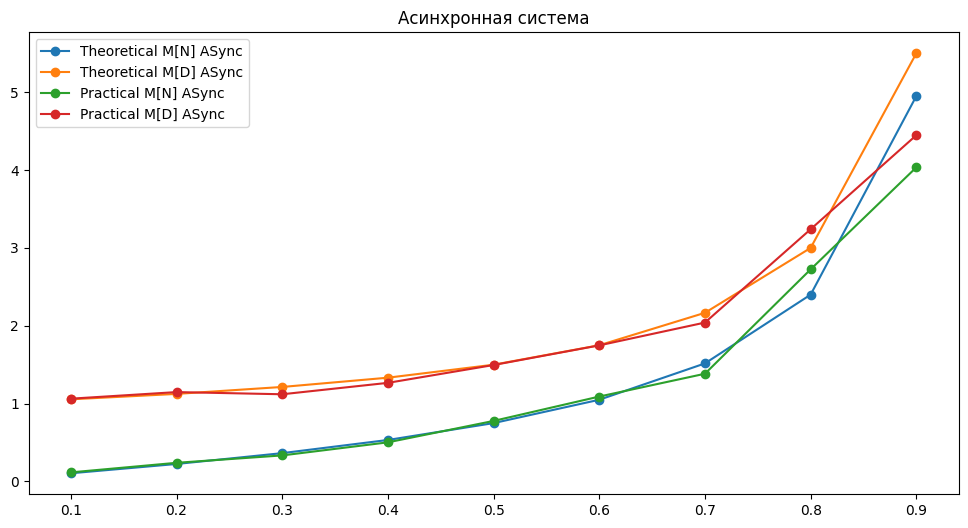

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(intensity, Theoretical_N_ASynchron, marker='o', label = 'Theoretical M[N] ASync')
plt.plot(intensity, Theoretical_D_ASynchron, marker='o', label = 'Theoretical M[D] ASync')
plt.plot(intensity, Practical_N_ASynchron, marker='o', label = 'Practical M[N] ASync')
plt.plot(intensity, Practical_D_ASynchron, marker='o', label = 'Practical M[D] ASync')
plt.title('Асинхронная система')
plt.legend()
plt.show()

In [11]:
def run_adaptive_aloha_simulation(M, lambd, num_windows):
    success_count = 0
    conflict_count = 0
    empty_count = 0

    p_t = 1.0 / M
    W_t = M
    
    for _ in range(num_windows):
        # Use Sync to get new tasks and update time slots
        practice_N, practice_D, k = Sync(lambd, selection)
        
        messages_ready = np.array([calc_poisson(lambd / M) > 0 for _ in range(M)])
        transmission_prob = np.random.rand(M)
        transmissions = (transmission_prob < p_t) & messages_ready
        total_transmissions = np.sum(transmissions)

        if total_transmissions == 0:
            empty_count += 1
            p_t = min(1.0, p_t * 2)
            W_t = max(1, W_t // 2)
        elif total_transmissions == 1:
            success_count += 1
        else:
            conflict_count += 1
            p_t = max(1.0 / M, p_t / 2)
            W_t = min(M, W_t * 2)

    return success_count, conflict_count, empty_count

Number of successful transmissions: 3666
Number of conflicts: 4063
Number of empty windows: 2271
Percentage of successful transfers: 36.66%


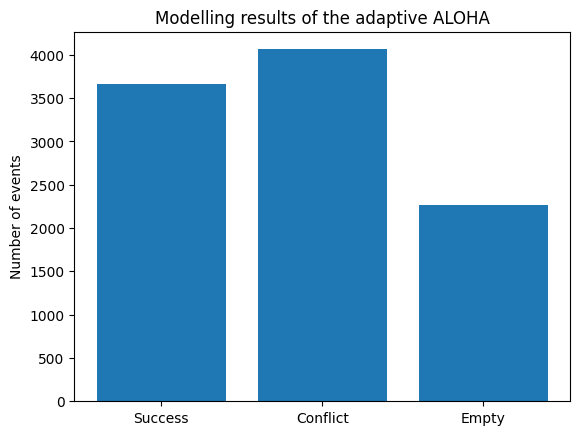

In [12]:
M = 4
lambda_param = 8
num_windows = 10000

success_count, conflict_count, empty_count = run_adaptive_aloha_simulation(M, lambda_param, num_windows)

print(f"Number of successful transmissions: {success_count}")
print(f"Number of conflicts: {conflict_count}")
print(f"Number of empty windows: {empty_count}")

total_attempts = success_count + conflict_count + empty_count
success_rate = (success_count / total_attempts) * 100 if total_attempts > 0 else 0
print(f"Percentage of successful transfers: {success_rate:.2f}%")

labels = ['Success', 'Conflict', 'Empty']
counts = [success_count, conflict_count, empty_count]

plt.bar(labels, counts)
plt.ylabel('Number of events')
plt.title('Modelling results of the adaptive ALOHA')
plt.show()

In [13]:
def exp(lambd):
    return -np.log(np.random.random()) / lambd

def calc_poisson(lambda_param):
    if lambda_param >= 1:
        return 1
    s = 0.0
    k = -1
    while True:
        s += exp(1)
        k += 1
        if not s < lambda_param:
            break
    return k

def initialize_random_tasks(lambd, num_windows):
    return [calc_poisson(lambd) for _ in range(num_windows)]

def run_adaptive_aloha_simulation(M, lambd, num_windows):
    
    success_count = 0
    conflict_count = 0
    empty_count = 0
    queue_lengths = []
    delays = []
    
    p_t = 1.0 / M
    queues = [[] for _ in range(M)]
    current_time = 0
    
    new_tasks = initialize_random_tasks(lambd, num_windows)
    
    for window in range(num_windows):
        if window < len(new_tasks):
            new_task_count = new_tasks[window]
            for _ in range(new_task_count):
                station = random.randint(0, M-1)
                queues[station].append(current_time)
        
        total_packets = sum(len(q) for q in queues)
        queue_lengths.append(total_packets)
        
        transmitting_stations = []
        for i in range(M):
            if queues[i] and random.random() < p_t:
                transmitting_stations.append(i)
        
        # Обработка результата передачи
        if len(transmitting_stations) == 0:
            empty_count += 1
            p_t = min(1.0, p_t * 1.5)
        elif len(transmitting_stations) == 1:
            success_count += 1
            station = transmitting_stations[0]
            entry_time = queues[station].pop(0)
            delays.append(current_time - entry_time)
        else:
            conflict_count += 1
            p_t = max(1.0 / (2 * M), p_t * 0.5)
        
        current_time += 1
    
    average_queue_length = statistics.mean(queue_lengths) if queue_lengths else 0
    average_delay = statistics.mean(delays) if delays else 0
    output_intensity = success_count / num_windows if num_windows > 0 else 0

    return success_count, conflict_count, empty_count, average_queue_length, average_delay, output_intensity

Number of successful transmissions: 21058
Number of conflicts: 15887
Number of empty windows: 23055
Percentage of successful transfers: 35.10%


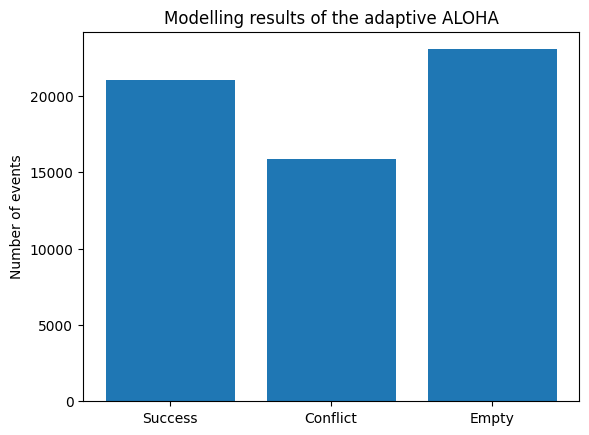

In [14]:
M = 10
lambd = 0.6
num_windows = 60000

success_count, conflict_count, empty_count, avg_practice_N, avg_practice_D, output_intensity = run_adaptive_aloha_simulation(M, lambd, num_windows)

print(f"Number of successful transmissions: {success_count}")
print(f"Number of conflicts: {conflict_count}")
print(f"Number of empty windows: {empty_count}")

total_attempts = success_count + conflict_count + empty_count
success_rate = (success_count / total_attempts) * 100 if total_attempts > 0 else 0
print(f"Percentage of successful transfers: {success_rate:.2f}%")

labels = ['Success', 'Conflict', 'Empty']
counts = [success_count, conflict_count, empty_count]

plt.bar(labels, counts)
plt.ylabel('Number of events')
plt.title('Modelling results of the adaptive ALOHA')
plt.show()

In [15]:
lambda_values = np.linspace(0.1, 0.9, 40)

throughputs = []
queue_lengths = []
delays = []

success_rates = [] 
conflict_rates = []
empty_rates = []

for lambda_param in lambda_values:
    success_count, conflict_count, empty_count, queue_length, delay, throughput = run_adaptive_aloha_simulation(M, lambda_param, num_windows)
    throughputs.append(throughput)
    queue_lengths.append(queue_length)
    delays.append(delay)

    success_rates.append(success_count / num_windows)
    conflict_rates.append(conflict_count / num_windows)
    empty_rates.append(empty_count / num_windows)

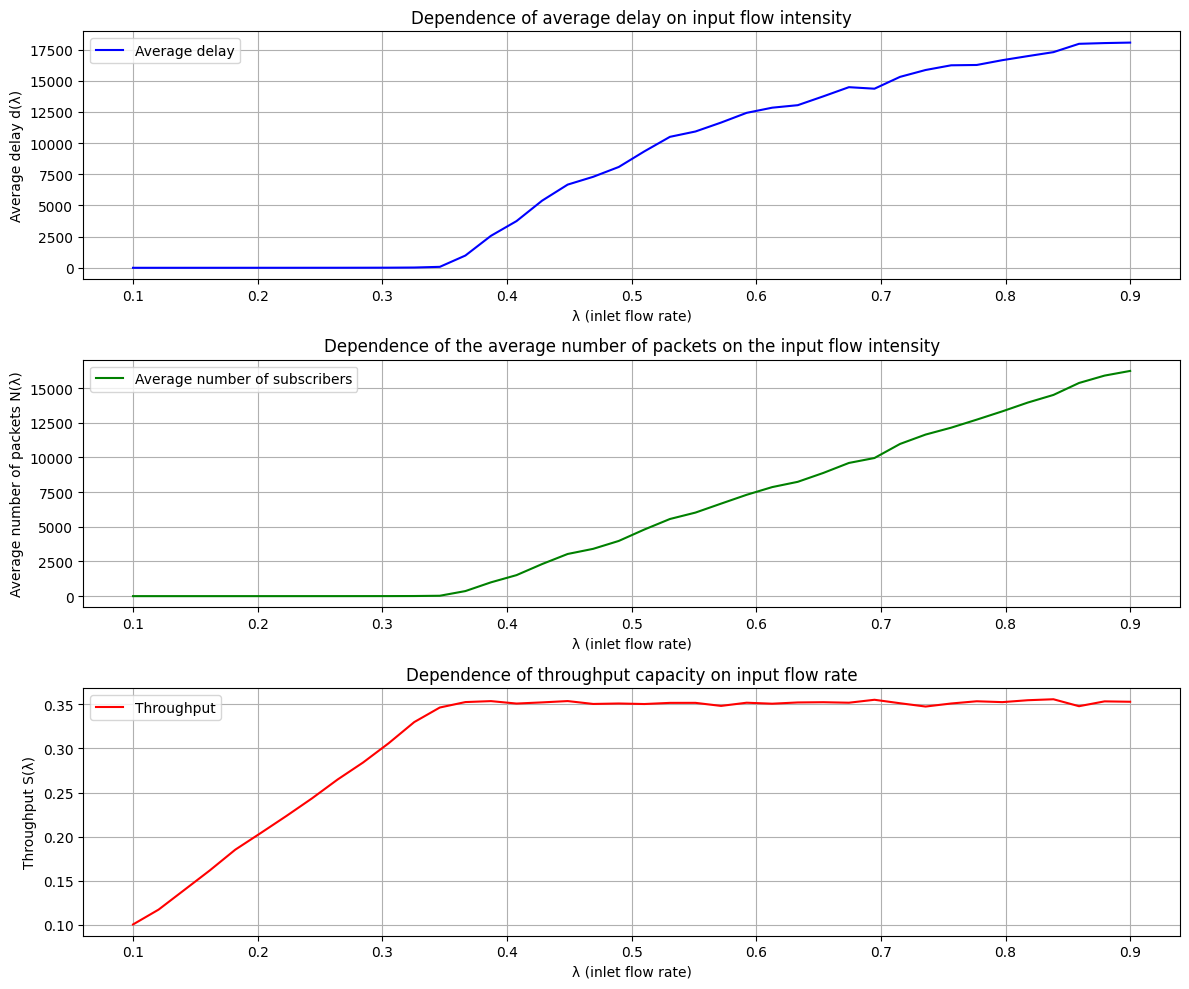

In [16]:
plt.figure(figsize=(12, 10))

# Средняя задержка
plt.subplot(3, 1, 1)
plt.plot(lambda_values, delays, 'b-', label='Average delay')
plt.xlabel('λ (inlet flow rate)')
plt.ylabel('Average delay d(λ)')
plt.title('Dependence of average delay on input flow intensity')
plt.grid(True)
plt.legend()

# Среднее число пакетов
plt.subplot(3, 1, 2)
plt.plot(lambda_values, queue_lengths, 'g-', label='Average number of subscribers')
plt.xlabel('λ (inlet flow rate)')
plt.ylabel('Average number of packets N(λ)')
plt.title('Dependence of the average number of packets on the input flow intensity')
plt.grid(True)
plt.legend()

# Пропускная способность
plt.subplot(3, 1, 3)
plt.plot(lambda_values, throughputs, 'r-', label='Throughput')
plt.xlabel('λ (inlet flow rate)')
plt.ylabel('Throughput S(λ)')
plt.title('Dependence of throughput capacity on input flow rate')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show() 

In [17]:
def print_cool_graph_with_params(m, num_windows, lambda_values):
    success_rates = []
    conflict_rates = []
    empty_rates = []

    for lambda_param in lambda_values:
        success_count, conflict_count, empty_count, _, _, _ = run_adaptive_aloha_simulation(m, lambda_param, num_windows)
        
        success_rates.append(success_count / num_windows)
        conflict_rates.append(conflict_count / num_windows)
        empty_rates.append(empty_count / num_windows)

    plt.figure(figsize=(10, 6))

    plt.plot(lambda_values, success_rates, label='Success', color='tab:green')
    plt.plot(lambda_values, conflict_rates, label='Conflict', color='tab:red')
    plt.plot(lambda_values, empty_rates, label='Empty', color='tab:blue')

    plt.xlabel('λ (input intensity)')
    plt.ylabel('windows rate')
    plt.title('share of successes, conflicts and empty windows from the input flow intensity')
    plt.legend()
    plt.grid(True)
    plt.show()    

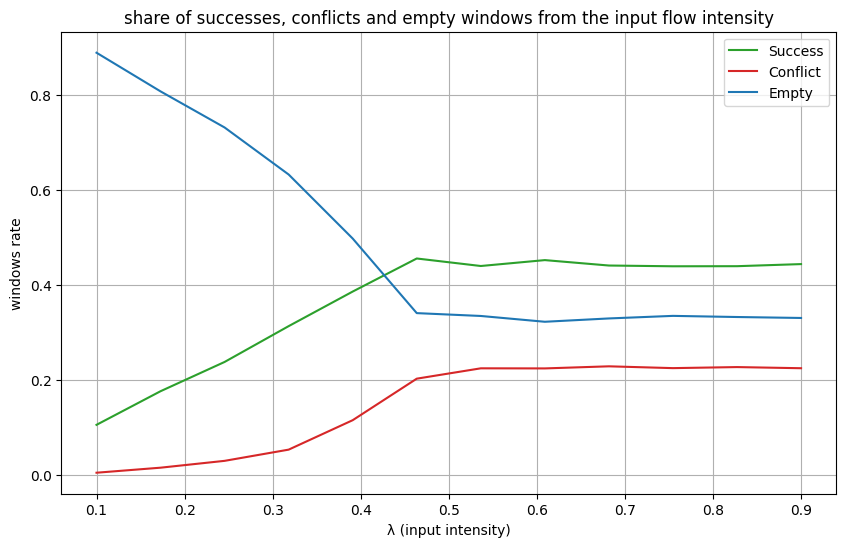

In [29]:
M = 2
num_windows = 5000
lambda_values = np.linspace(0.1, 0.9, 12)
print_cool_graph_with_params(M, num_windows, lambda_values)

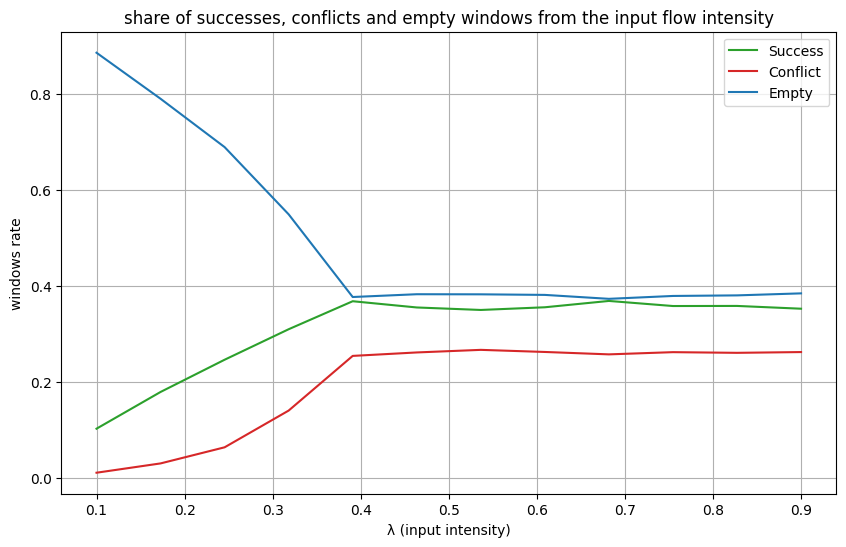

In [28]:
M = 8
num_windows = 5000
lambda_values = np.linspace(0.1, 0.9, 12)
print_cool_graph_with_params(M, num_windows, lambda_values)

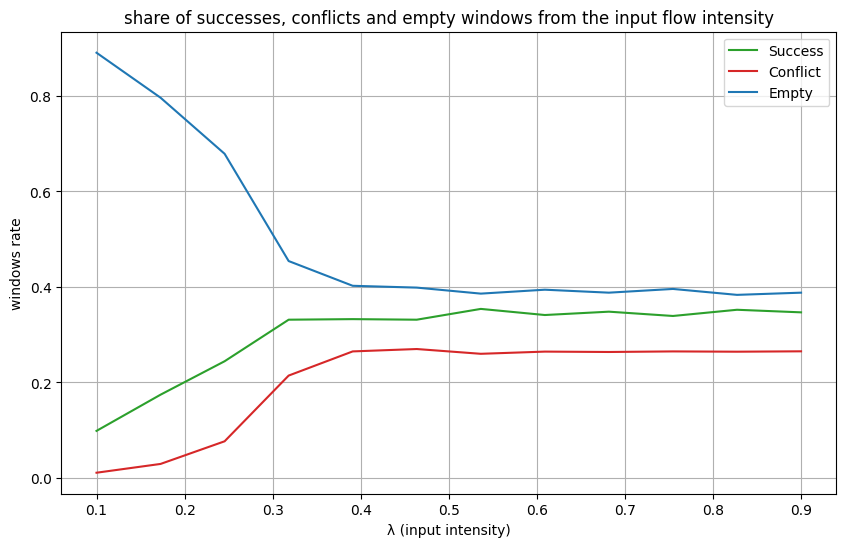

In [26]:
M = 20
num_windows = 5000
lambda_values = np.linspace(0.1, 0.9, 12)
print_cool_graph_with_params(M, num_windows, lambda_values)